# AI-text-detector

In [50]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import numpy as np
import seaborn as sns
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# optim
import torch.optim as optim

## Training

In [51]:
# load texts and labels
def load_data():

    import os

    data = {
        'human': [],
        'bot': []
    }

    for filename in os.listdir('data/heste-nettet-nyheder'):
        with open('data/heste-nettet-nyheder/' + filename, 'r', encoding='utf-8') as f:
            content = f.read()
            text = '\n'.join(content.split('\n')[2:])
            data['human'].append(text)

    for filename in os.listdir('data/heste-nettet-nyheder-ai/gpt-3.5-turbo/'):
        with open('data/heste-nettet-nyheder-ai/gpt-3.5-turbo/' + filename, 'r', encoding='utf-8') as f:
            content = f.read()
            text = '\n'.join(content.split('\n')[2:])
            data['bot'].append(text)

    my_texts = np.array(data['human'] + data['bot'])
    my_labels = np.array([0]*len(data['human']) + [1]*len(data['bot'])) 
    

    return list(my_texts), my_labels

def preprocess(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")
    return inputs

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.inputs = preprocess(texts)

        # dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
        self.input_ids = self.inputs['input_ids']
        self.attention_mask = self.inputs['attention_mask']

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        input_ids = self.input_ids[idx]
        attention_mask = self.attention_mask[idx]

        return {
            # 'text': text,
            'label': label,
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }

model_name = "bert-base-multilingual-cased"  # or another model suitable for Danish
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

texts, labels = load_data()
texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, test_size=0.2)

dataset_train = TextDataset(texts_train, labels_train)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_test = TextDataset(texts_test, labels_test)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)


# print table summary with total samples in each dataset, positive samples, and negative samples
def pretty_print_info_table(labels_train, labels_test):
    data_for_table = {
        'train': {
            'total': len(labels_train),
            'pos': np.sum(labels_train),
            'neg': len(labels_train) - np.sum(labels_train)
        },
        'test': {
            'total': len(labels_test),
            'pos': np.sum(labels_test),
            'neg': len(labels_test) - np.sum(labels_test)
        }
    }
    data_for_table['total'] = {
        'total': data_for_table['train']['total'] + data_for_table['test']['total'],
        'pos': data_for_table['train']['pos'] + data_for_table['test']['pos'],
        'neg': data_for_table['train']['neg'] + data_for_table['test']['neg']
    }

    print("""
    Info table:
    +----------------+---------+---------+-------+
    |                | Training| Testing | Total
    +----------------+---------+---------+-------+
    | Total samples  | {:7d} | {:7d} | {:7d} |
    | Pos. samples   | {:7d} | {:7d} | {:7d} |  (AI generated)
    | Neg. samples   | {:7d} | {:7d} | {:7d} |  (Human written)
    """.format(
        data_for_table['train']['total'],
        data_for_table['test']['total'],
        data_for_table['total']['total'],
        data_for_table['train']['pos'],
        data_for_table['test']['pos'],
        data_for_table['total']['pos'],
        data_for_table['train']['neg'],
        data_for_table['test']['neg'],
        data_for_table['total']['neg'],
        
        ))

pretty_print_info_table(labels_train, labels_test)

# weight for positive class
weight_pos = len(texts_train) / (2 * np.sum(labels_train))
# weight for negative class
weight_neg = len(texts_train) / (2 * (len(texts_train) - np.sum(labels_train)))
# class weights
class_weights = torch.tensor([weight_neg, weight_pos])

# the class weights are defined, but im unsure how to apply them as the loss function is incooperated in the forward pass of the model, so i will just balance the dataset instead.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



    Info table:
    +----------------+---------+---------+-------+
    |                | Training| Testing | Total
    +----------------+---------+---------+-------+
    | Total samples  |     940 |     236 |    1176 |
    | Pos. samples   |     134 |      33 |     167 |  (AI generated)
    | Neg. samples   |     806 |     203 |    1009 |  (Human written)
    


Using device: mps
Epoch 0 loss: 0.0146058034389577
Epoch 0 test loss: 0.010669170547339875
Epoch 1 loss: 0.006993990328083647
Epoch 1 test loss: 0.004454486924460379
Epoch 2 loss: 0.003763064872869786
Epoch 2 test loss: 0.0031277355501207254
Epoch 3 loss: 0.0020997075433347454
Epoch 3 test loss: 0.004017492779925213
Epoch 4 loss: 0.0007934799204838086
Epoch 4 test loss: 0.0009096783859126459
Epoch 5 loss: 0.0004674234189727205
Epoch 5 test loss: 0.0028621166908987246
Epoch 6 loss: 0.00012630233516361804
Epoch 6 test loss: 0.000183215719485908
Epoch 7 loss: 8.464512610907091e-05
Epoch 7 test loss: 0.00030068304415366027
Epoch 8 loss: 6.303256885346738e-05
Epoch 8 test loss: 0.0002441666847671051
Epoch 9 loss: 4.947176896669763e-05
Epoch 9 test loss: 0.000227395102028514
Epoch 10 loss: 4.1903035735037733e-05
Epoch 10 test loss: 0.000284532638033852
Epoch 11 loss: 3.585219928162529e-05
Epoch 11 test loss: 0.00027836774775789956
Epoch 12 loss: 3.1208838930630934e-05
Epoch 12 test loss: 0.0

Text(0, 0.5, 'Loss')

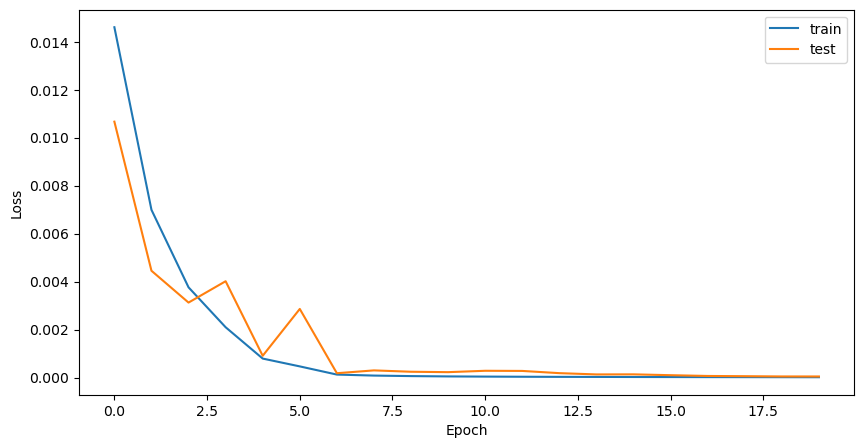

In [52]:
# Assume you're using a GPU for training
device = torch.device("mps" if torch.has_mps else "cpu")
print("Using device:", device)
model.to(device)

# Training loop
from transformers import AdamW
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

# early stopping
def early_stopping(losses, patience=3):
    if len(losses) < patience:
        return False
    return losses[-1] > losses[-2] > losses[-3]

losses = {'train': [], 'test': []}
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    # Train
    loss_total_train = 0
    for i, batch in enumerate(dataloader_train):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)


        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        #rint(outputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        loss_total_train += loss.item()

    print(f"Epoch {epoch} loss: {loss_total_train / len(dataset_train)}")
    losses['train'].append(loss_total_train / len(dataset_train))

    # Test
    model.eval()
    loss_total_test = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader_test):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss_total_test += loss.item()

    print(f"Epoch {epoch} test loss: {loss_total_test / len(dataset_test)}")
    losses['test'].append(loss_total_test / len(dataset_test))

    if early_stopping(losses['test']):
        print("Early stopping")
        break

# Save the model
model.save_pretrained("models/bert_classifier", save_function=torch.save)

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(losses['train'], label='train')
plt.plot(losses['test'], label='test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')


## Model Validation

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       203
           1       1.00      1.00      1.00        33

    accuracy                           1.00       236
   macro avg       1.00      1.00      1.00       236
weighted avg       1.00      1.00      1.00       236



Text(0.5, 1.0, 'Confusion matrix for BERT detector, for detecting AI generated texts')

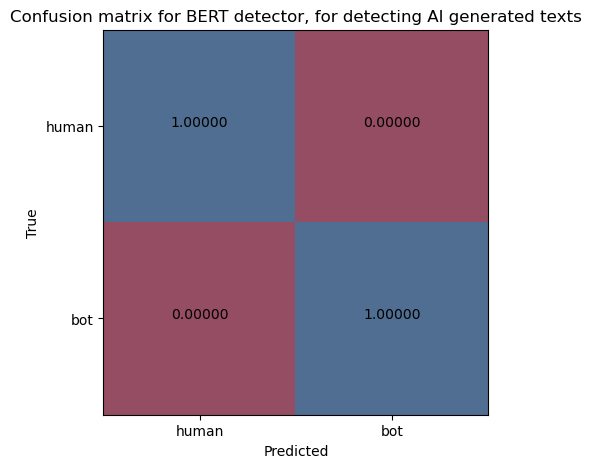

In [53]:
# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for i, batch in enumerate(dataloader_test):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(logits.argmax(dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, predictions))

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(5, 5))
plt.imshow(cm, cmap=plt.cm.RdBu, alpha=.7 )

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, "{:.5f}".format(cm[i, j]), horizontalalignment="center")

plt.xticks([0, 1], ['human', 'bot'])
plt.yticks([0, 1], ['human', 'bot'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix for BERT detector, for detecting AI generated texts")

## Model Application

In [54]:
# load my model
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("models/bert_classifier")
model.to(device);

In [55]:
# test
test_string = "This is a test"

model.eval()    
with torch.no_grad():
    inputs = preprocess(test_string)
    input_ids = inputs['input_ids'].squeeze(1).to(device)
    attention_mask = inputs['attention_mask'].squeeze(1).to(device)
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    print(logits)
    print(torch.argmax(logits).item())

tensor([[ 3.3534, -3.1860]], device='mps:0')
0


## Ftitting it into router format

In [56]:
# to fit into the pipeline i need to make a predict function

def predict(text):
    model.eval()    
    with torch.no_grad():
        inputs = preprocess(text)
        input_ids = inputs['input_ids'].squeeze(1).to(device)
        attention_mask = inputs['attention_mask'].squeeze(1).to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        return torch.argmax(logits).item()

# test
test_string = "This is a test"
print(predict(test_string))

0
